## Read in data

In [1]:
import pandas as pd
import numpy as np

In [6]:
oo = pd.read_csv('../data/online_retail_small.csv')

In [3]:
cd ../ddf/

/home/vik/NUS/artificial-dataset-generation/ddf


In [4]:
from ddf.stainer import Stainer, RowDuplicateStainer
from ddf.DirtyDF import DirtyDF
from numpy.random import default_rng
from time import time
rng= default_rng()

In [7]:
d1 = oo.sample(n=4)

In [11]:
d2 = oo.sample(n=4)
d2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
858,536464,85231B,CINAMMON SET OF 9 T-LIGHTS,2,1/12/2010 12:23,0.85,17968.0,United Kingdom
265,536395,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1/12/2010 10:47,1.69,13767.0,United Kingdom
1232,536531,22193,RED DINER WALL CLOCK,4,1/12/2010 13:23,8.50,15485.0,United Kingdom
2743,536592,22536,MAGIC DRAWING SLATE PURDEY,1,1/12/2010 17:06,0.85,NaN,United Kingdom


## Column splitter

In [12]:
class ColumnSplitter(Stainer):
    """ Stainer to split text columns, creating a ragged DataFrame """
    
    def __init__(self, name = "Column splitter", col_idx = [], regex_string=" "):
        """ Constructor for ColumnSplitter
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This has to be a single integer. This is 
                 the column that will be split into two.
        regex_string: The string to split the column on. For instance, "(?=-)" is a
                 look-ahead assertion that splits on a hyphen. Using lookahead or 
                 look-behind strings ensures that the splitting character is retained.
                 
                 
        Raises
        ------
        ValueError
            If col_idx is missing, or is length greater than 1.
        """
        if ((type(col_idx) is not list) or (len(col_idx) != 1)):
            raise ValueError("col_idx must be a list with a single integer.")
        super().__init__(name, [], col_idx)
        self.regex_string = regex_string
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator. Unused by this stainer.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
            Modified dataframe, with one extra column on the right.
        row_map : empty dictionary
            Row mapping showing the relationship between the original and new row positions.
        col_map : A dictionary
            Generating the column map is tricky in this situation, because after the split column,
            on the right, each column actually contains information from two original columns. One option 
            is to indicate which two columns each new column maps to, but, since most of the original 
            columns were retained, we only indicate that the right-most column has been mapped to the
            last two of the new dataframe.
       
        >>> rng = np.random.default_rng(12)
        >>> x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'price': [2.30, 3.20]})
        >>> print(x)
             label  price
        0  T-LIGHT    2.3
        1  ASHTRAY    3.2
        
        >>> cc = ColumnSplitter(col_idx=[0], regex_string="(?=-)")
        >>> new_x, rmap, cmap = cc.transform(x, rng)
        >>> print(new_x) # see the ragged dataframe.. it contains unnamed column on the right.
             label   price     
        0        T  -LIGHT  2.3
        1  ASHTRAY     3.2  NaN
        
        >>> print(cmap)
        {0: [0], 1: [1, 2]}
        
        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()
        
        org_col_index = new_df.columns
        col_name = org_col_index[col_idx[0]]
        split_id = np.argwhere(org_col_index == col_name).reshape(1)[0]
        
        # split the original df into three sections: 
        # to_keep, col_to_split and cols_to_join_back
        to_keep = new_df.iloc[:, :split_id].copy(deep=True)
        to_split = df[[col_name]].copy(deep=True)
        to_join = df.iloc[:, (split_id+1):].copy(deep=True)
        cols_to_add = np.hstack((org_col_index[(split_id+1):], ''))
        to_join[''] = pd.Series([np.NaN]*to_join.shape[0])
        
        #split the column:
        to_split = to_split[col_name].str.split(self.regex_string, n=1, expand=True)
        to_split.columns = [col_name, cols_to_add[0]]
        
        # join the split column back first
        #to_keep = pd.concat([to_keep, to_split], axis=1)
        to_keep = to_keep.join(to_split)
        na_boolean = to_keep[cols_to_add[0]].isna()
        to_keep = to_keep.combine_first(to_join[[cols_to_add[0]]])
        #breakpoint()
        
        for i in np.arange(1,len(cols_to_add)):
            #print(i)
            new_col = to_join.iloc[:, i].copy(deep=True)
            new_col[~na_boolean] = to_join.iloc[:, i-1][~na_boolean]
            to_keep = pd.concat([to_keep, new_col], axis=1)
            #print(cols_to_add[i])
        #print(cols_to_add)
        #return to_keep[np.hstack((org_col_index, ''))]
        
        # create col-map:
        cmap = {}
        for ii in np.arange(df.shape[1]):
            cmap[ii] = [ii]
        cmap[df.shape[1]-1] = [df.shape[1]-1, df.shape[1]]
        # print(cmap)
        
        end = time()
        self.update_history(f"Column id {col_name} split into two.", end-start)
        self.update_history(message = f"New dataframe has {to_keep.shape[1]} columns now.")
        return to_keep[np.hstack((org_col_index, ''))],{},cmap

In [13]:
import doctest
doctest.run_docstring_examples(ColumnSplitter.transform, globs=None, verbose=True)

Finding tests in NoName
Trying:
    rng = np.random.default_rng(12)
Expecting nothing
ok
Trying:
    x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'price': [2.30, 3.20]})
Expecting nothing
ok
Trying:
    print(x)
Expecting:
         label  price
    0  T-LIGHT    2.3
    1  ASHTRAY    3.2
ok
Trying:
    cc = ColumnSplitter(col_idx=[0], regex_string="(?=-)")
Expecting nothing
ok
Trying:
    new_x, rmap, cmap = cc.transform(x, rng)
Expecting nothing
ok
Trying:
    print(new_x) # see the ragged dataframe.. it contains unnamed column on the right.
Expecting:
         label   price     
    0        T  -LIGHT  2.3
    1  ASHTRAY     3.2  NaN
ok
Trying:
    print(cmap)
Expecting:
    {0: [0], 1: [1, 2]}
ok


----

In [15]:
rng = np.random.default_rng(12)
x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'price': [2.30, 3.20]})
cc = ColumnSplitter(col_idx=[0], regex_string="(?=-)")
new_x, rmap, cmap = cc.transform(x, rng)

In [16]:
print(new_x)

     label   price     
0        T  -LIGHT  2.3
1  ASHTRAY     3.2  NaN


In [17]:
print(x)

     label  price
0  T-LIGHT    2.3
1  ASHTRAY    3.2


In [18]:
print(cmap)

{0: [0], 1: [1, 2]}


In [22]:
cc = ColumnSplitter(col_idx=[2], regex_string="(?=-)")
cc.transform(d2, rng)

(     InvoiceNo StockCode                    Description Quantity  \
 858     536464    85231B            CINAMMON SET OF 9 T  -LIGHTS   
 265     536395     84879  ASSORTED COLOUR BIRD ORNAMENT       32   
 1232    536531     22193           RED DINER WALL CLOCK        4   
 2743    536592     22536     MAGIC DRAWING SLATE PURDEY        1   
 
           InvoiceDate        UnitPrice  CustomerID         Country  \
 858               2.0  1/12/2010 12:23        0.85         17968.0   
 265   1/12/2010 10:47             1.69    13767.00  United Kingdom   
 1232  1/12/2010 13:23              8.5    15485.00  United Kingdom   
 2743  1/12/2010 17:06             0.85         NaN  United Kingdom   
 
                       
 858   United Kingdom  
 265              NaN  
 1232             NaN  
 2743             NaN  ,
 {},
 {0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 8]})

In [158]:
d2.shape

(4, 8)

---

In [128]:
d2.index

Int64Index([730, 3582, 4338, 3163], dtype='int64')

In [142]:
d2.index = np.arange(4) # this should be fixed, currently only works with 0..n-1 index
                        # not true - original indexing can be used, but the output index will be 0...(n-1)
#d2

#rr= RowDuplicateStainer(deg=1/3, name='test dup row map', row_idx=[730, 3582])
rr= RowDuplicateStainer(deg=1/3, name='test dup row map', row_idx=[0,1,2])

#ddf1 = DirtyDF(d2, seed=1)
#ddf1 = ddf1.add_stainers(rr)
#ddf2 = ddf1.run_stainer()
#ddf2.get_df()
df,rmap,colmap = rr.transform(d2, rng)

In [140]:
rmap

{0: [0], 1: [1], 2: [2, 3], 3: [4]}

In [146]:
cmap = {}
#cmap.keys() = df.index

In [149]:
for ii in df.index:
    cmap[ii] = [ii]

In [151]:
cmap

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4]}

In [143]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536783,35001G,HAND OPEN SHAPE GOLD,42,2/12/2010 15:19,3.39,15061.0,United Kingdom
1,536408,21587,COSY HOUR GIANT TUBE MATCHES,12,1/12/2010 11:41,2.55,14307.0,United Kingdom
2,536617,85116,BLACK CANDELABRA T-LIGHT HOLDER,96,2/12/2010 10:17,0.65,13941.0,United Kingdom
3,536617,85116,BLACK CANDELABRA T-LIGHT HOLDER,96,2/12/2010 10:17,0.65,13941.0,United Kingdom
4,536592,21520,BOOZE & WOMEN GREETING CARD,1,1/12/2010 17:06,0.85,NaN,United Kingdom


In [116]:
rmap

{0: [0], 1: [1, 2], 2: [3], 3: [4]}

In [117]:
d2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536569,22639,SET OF 4 NAPKIN CHARMS HEARTS,1,1/12/2010 15:35,2.55,16274.0,United Kingdom
1,536813,22042,CHRISTMAS CARD SINGING ANGEL,12,2/12/2010 16:59,0.42,15646.0,United Kingdom
2,536522,22481,BLACK TEA TOWEL CLASSIC DESIGN,3,1/12/2010 12:49,1.25,15012.0,United Kingdom
3,536796,84952C,MIRROR LOVE BIRD T-LIGHT HOLDER,1,2/12/2010 15:46,3.75,15574.0,United Kingdom


---

NoneType

In [61]:
cc = ColumnSplitter(col_idx=[5])

In [6]:
d2 = oo.sample(n=4)

In [7]:
d2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2432,536591,21789,KIDS RAIN MAC PINK,1,1/12/2010 16:57,0.85,14606.0,United Kingdom
2063,536557,21486,PINK HEART DOTS HOT WATER BOTTLE,2,1/12/2010 14:41,3.75,17841.0,United Kingdom
857,536464,85231G,ORANGE SCENTED SET/9 T-LIGHTS,1,1/12/2010 12:23,0.85,17968.0,United Kingdom
3517,536635,84375,SET OF 20 KIDS COOKIE CUTTERS,12,2/12/2010 11:22,2.10,15955.0,United Kingdom


In [7]:
d2.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
# original implementation

def column_splitter(df, col_name, regex_string="(?=-)"):
    org_col_index = df.columns
    split_id = np.argwhere(org_col_index == col_name).reshape(1)[0]
    
    # split the original df into three sections: 
    # to_keep, col_to_split and cols_to_join_back
    to_keep = df.iloc[:, :split_id].copy(deep=True)
    to_split = df[[col_name]].copy(deep=True)
    to_join = df.iloc[:, (split_id+1):].copy(deep=True)
    cols_to_add = np.hstack((org_col_index[(split_id+1):], ''))
    to_join[''] = pd.Series([np.NaN]*to_join.shape[0])
    
    #split the column:
    to_split = to_split[col_name].str.split(regex_string, n=1, expand=True)
    to_split.columns = [col_name, cols_to_add[0]]
    
    # join the split column back first
    #to_keep = pd.concat([to_keep, to_split], axis=1)
    to_keep = to_keep.join(to_split)
    na_boolean = to_keep[cols_to_add[0]].isna()
    to_keep = to_keep.combine_first(to_join[[cols_to_add[0]]])
    #breakpoint()
    
    for i in np.arange(1,len(cols_to_add)):
        #print(i)
        new_col = to_join.iloc[:, i].copy(deep=True)
        new_col[~na_boolean] = to_join.iloc[:, i-1][~na_boolean]
        to_keep = pd.concat([to_keep, new_col], axis=1)
        #print(cols_to_add[i])
    #print(cols_to_add)
    
    return to_keep[np.hstack((org_col_index, ''))]

In [9]:
column_splitter(d2, 'Description')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,
2665,536592,22169,FAMILY ALBUM WHITE PICTURE FRAME,1,1/12/2010 17:06,16.98,NaN,United Kingdom,NaN
4337,536763,21733,RED HANGING HEART T,-LIGHT HOLDER,6.0,2/12/2010 14:42,2.95,17685.0,United Kingdom
1609,536544,22569,FELTCRAFT CUSHION BUTTERFLY,1,1/12/2010 14:32,7.62,NaN,United Kingdom,NaN
1906,536544,21121,SET/10 RED POLKADOT PARTY CANDLES,7,1/12/2010 14:32,2.51,NaN,United Kingdom,NaN


## Column joiner

In [23]:
telco = pd.read_csv("../data/Telco-Customer-Churn.csv")

In [24]:
telco_sub = telco.sample(n=10)
telco_sub

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5390,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes
4025,2984-MIIZL,Male,0,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.80,321.90,Yes
5187,2080-CAZNM,Female,1,No,No,41,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,104.40,4133.95,No
2143,4079-VTGLK,Male,1,Yes,No,30,Yes,Yes,DSL,No,...,Yes,No,Yes,Yes,Two year,No,Electronic check,74.85,2181.75,No
5457,9496-IVVRP,Female,0,Yes,Yes,11,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),51.00,581.70,No
6972,6664-FPDAC,Female,1,No,No,56,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,111.95,6418.90,Yes
3950,5655-JSMZM,Male,1,No,No,49,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,96.20,4718.25,Yes
4210,5446-DKWYW,Female,1,Yes,Yes,61,Yes,Yes,DSL,No,...,Yes,No,Yes,No,One year,Yes,Electronic check,65.20,3965.05,No
81,8108-UXRQN,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,Yes,Yes,Month-to-month,No,Electronic check,50.55,565.35,No
4865,1355-KUSBG,Female,0,Yes,Yes,7,Yes,Yes,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,48.80,349.80,No


In [25]:
d3 = telco.copy(deep=True)

d3 = d3.reindex()

In [26]:
class ColumnJoiner(Stainer):
    """ Stainer to join text columns, creating a ragged DataFrame """
    
    def __init__(self, name = "Column splitter", row_idx =[], col_idx = []):
        """ Constructor for ColumnJoiner
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This has to contain two consecutive integers. These are 
                 the columns that will be catenated.
        row_idx: int list, required. These will be the rows that will be "shifted" inwards.
                 
        Raises
        ------
        ValueError
            If col_idx has length not equals to two, or the values are not consecutive.
        ValueError
            If row_idx is empty.
        """
        if ((len(col_idx) != 2) or (col_idx[1] - col_idx[0] != 1)):
            raise ValueError("col_idx must contain two consecutive integers.")
        if(len(row_idx) == 0):
            raise ValueError("row_idx should not be empty.")
        super().__init__(name, row_idx, col_idx)
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator. Unused by this stainer.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
            Modified dataframe, with some columns shifted "inwards"
        row_map : empty dictionary.
        col_map : empty dictionary.
       
        >>> rng = np.random.default_rng(12)
        >>> x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'dept':['A1', 'A2'], 'price': [2.30, 3.20]})
        >>> print(x)
             label dept  price
        0  T-LIGHT   A1    2.3
        1  ASHTRAY   A2    3.2

        >>> cj1 = ColumnJoiner('test joiner', [1], [0,1])
        >>> print(cj1.transform(x, rng))
               label dept  price
        0    T-LIGHT   A1    2.3
        1  ASHTRAYA2  3.2    NaN
        
        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()
                
        org_col_index = new_df.columns
        col_names = org_col_index[col_idx]
        
        split_id = np.argwhere(org_col_index == col_names[1]).reshape(1)[0]
        to_keep = new_df.loc[:, :col_names[0]].copy(deep=True)
        join_series = new_df[col_names[1]].copy(deep=True)
        to_join = new_df.iloc[:, split_id:].copy(deep=True)

        # breakpoint()
        # modify the column to join, and paste with to_keep
        join_series[~join_series.index.isin(row_idx)] = ''
        to_keep[col_names[0]] = to_keep[col_names[0]] + join_series
        
        for i in np.arange(split_id, new_df.shape[1]):
            # print(i)
            new_col = new_df.iloc[:, i].copy(deep=True)
            if i < (new_df.shape[1] - 1):
                new_col[row_idx] = new_df.iloc[:, i+1][row_idx]
            else:
                new_col[row_idx] = np.NaN
            to_keep = pd.concat([to_keep, new_col], axis=1)
            #breakpoint()
        
        end = time()
        self.update_history(f"Column id {col_names[0]} and {col_names[1]} joined at certain rows.", end-start)
        return to_keep,{},{}

In [27]:
dd = ColumnJoiner('test', [1,4], [8, 9])
dd.transform(d3, rng)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSLYes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,NaN
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber opticNo,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [28]:
doctest.run_docstring_examples(dd.transform , globs=None, verbose=True)

Finding tests in NoName
Trying:
    rng = np.random.default_rng(12)
Expecting nothing
ok
Trying:
    x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'dept':['A1', 'A2'], 'price': [2.30, 3.20]})
Expecting nothing
ok
Trying:
    print(x)
Expecting:
         label dept  price
    0  T-LIGHT   A1    2.3
    1  ASHTRAY   A2    3.2
ok
Trying:
    cj1 = ColumnJoiner('test joiner', [1], [0,1])
Expecting nothing
ok
Trying:
    print(cj1.transform(x, rng))
Expecting:
           label dept  price
    0    T-LIGHT   A1    2.3
    1  ASHTRAYA2  3.2    NaN
ok


In [133]:
c1 = join_fn(telco_sub.MultipleLines, telco_sub.InternetService)

In [63]:
def join_fn(v1, v2):
    return (v1 == 'No phone service') & (v2 == 'DSL')

In [137]:
def column_joiner(df, col_name1, col_name2, join_criteria):
    # join_index should be a boolean index that indicates which rows to join.
    # use *row_idx* when we implement the stainer.
    
    org_col_index = df.columns
    split_id = np.argwhere(org_col_index == col_name2).reshape(1)[0]
    to_keep = df.loc[:, :col_name1].copy(deep=True)
    join_series = df[col_name2].copy(deep=True)
    to_join = df.iloc[:, split_id:].copy(deep=True)
    
    # breakpoint()
    # modify the column to join, and paste with to_keep
    join_series[~join_criteria] = ''
    to_keep[col_name1] = to_keep[col_name1] + join_series
    
    for i in np.arange(split_id, df.shape[1]):
        # print(i)
        new_col = df.iloc[:, i].copy(deep=True)
        if i < (df.shape[1] - 1):
            new_col[join_criteria] = df.iloc[:, i+1][join_criteria]
        else:
            new_col[join_criteria] = np.NaN
        to_keep = pd.concat([to_keep, new_col], axis=1)
        #breakpoint()

    return to_keep

In [138]:
out = column_joiner(telco_sub, 'MultipleLines', 'InternetService', c1)

In [142]:
telco_sub.loc[:, 'MultipleLines':]

,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6279,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.95,926.25,No
4345,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.55,1403.10,No
3449,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,One year,Yes,Credit card (automatic),95.70,4976.15,No
2081,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),75.30,1702.90,No
6684,No phone service,DSL,Yes,No,No,Yes,No,No,One year,Yes,Mailed check,36.05,402.60,No
2394,Yes,Fiber optic,No,Yes,No,No,No,No,One year,Yes,Credit card (automatic),79.05,5552.50,No
1511,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),19.25,1372.90,No
1584,No phone service,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),53.50,3517.90,No
867,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.30,No
779,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.35,89.50,Yes


---

## Resample residuals

In [29]:
from statsmodels.regression.linear_model import OLS, WLS
from statsmodels.tools import add_constant
from ddf.samplers import rand_from_Finv

In [61]:
class ResidualResampler(Stainer):
    """ Stainer to resample residuals from a linear model and return new y's. """
    
    def __init__(self, name = "Residual resampler", row_idx =[], col_idx = []):
        """ Constructor for ResidualResampler
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This should specify at least two columns. The first will
                 be used as the y-variable, and the others will be used as the X matrix.
        row_idx: int list, unused.
                 
        Raises
        ------
        ValueError
            If col_idx has length not equals to two, or the values are not consecutive.
        """
        if len(col_idx) < 2:
            raise ValueError("col_idx must contain at least two integers.")
        super().__init__(name, row_idx, col_idx)
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        A ordinary least squares linear model is fit, using statsmodels. The residuals are then
        sampled from using rand_from_Finv (from ddf.samplers) and added back to the fitted y-hats
        to create a new set of y-values.
        
        This stainer should result in a similar fit, but slightly different diagnostics/statistics.
        
        The user should check if the new y-values are valid or not (e.g. are they negative when they 
        shouldn't be?)
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
            Modified dataframe, with some columns shifted "inwards"
        row_map : empty dictionary.
        col_map : empty dictionary.
       
        >>> rng = np.random.default_rng(12)
        >>> x = np.arange(1, 11)
        >>> y = x*2.3 + 3 + rng.normal(scale=1.6, size=10)
        >>> org_df = pd.DataFrame({'x':x, 'y':y})

        >>> rr = ResidualResampler('test rr', [], [1,0])
        >>> new_df = rr.transform(org_df, rng)

        >>> print(pd.concat((org_df, new_df), axis=1))
            x          y   x          y
        0   1   5.289077   1   4.155549
        1   2   9.273829   2   8.747416
        2   3  11.086541   3   8.444612
        3   4  13.358330   4  11.250526
        4   5  17.090042   5  14.005535
        5   6  14.871107   6  16.610120
        6   7  18.096871   7  18.940797
        7   8  19.286939   8  23.466323
        8   9  23.527596   9  21.974412
        9  10  27.598022  10  23.545538

        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()
        
        # drop missing values
        col_names = new_df.columns[col_idx]
        fit_df = new_df.iloc[:, col_idx].dropna()
        
        X = add_constant(fit_df.iloc[:, 1:])
        y = fit_df.iloc[:,0]
    
        # fit and predict from the model
        m = OLS(y, X)
        o = m.fit()
        new_resid = rand_from_Finv(o.resid, rng, size=len(o.resid))
        new_y = o.predict(X) + new_resid
        
        # only put new values where we could predict values; otherwise keep old y-values.
        new_df.loc[y.index, col_names[0]] = new_y
        
        end = time()
        self.update_history(f"New y-values in column {col_idx[0]} by sampling from residual distribution.", 
                            end-start)
        return new_df,{},{}

In [63]:
rr = ResidualResampler('test rr', [], [5, 19])
rr.transform(telco, rng).head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,13.876093,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,33.985410,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,5.160247,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,13.372808,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,30.227722,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [81]:
rng = np.random.default_rng(12)
x = np.arange(1, 11)
y = x*2.3 + 3 + rng.normal(scale=1.6, size=10)
org_df = pd.DataFrame({'x':x, 'y':y})

rr = ResidualResampler('test rr', [], [1,0])
new_df = rr.transform(org_df, rng)

#import matplotlib.pyplot as plt
#%matplotlib inline

print(pd.concat((org_df, new_df), axis=1))

    x          y   x          y
0   1   5.289077   1   4.155549
1   2   9.273829   2   8.747416
2   3  11.086541   3   8.444612
3   4  13.358330   4  11.250526
4   5  17.090042   5  14.005535
5   6  14.871107   6  16.610120
6   7  18.096871   7  18.940797
7   8  19.286939   8  23.466323
8   9  23.527596   9  21.974412
9  10  27.598022  10  23.545538


<AxesSubplot:xlabel='x', ylabel='y'>

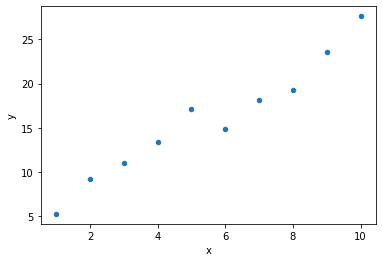

In [85]:
org_df.plot(x='x', y='y', kind='scatter')

<AxesSubplot:xlabel='x', ylabel='y'>

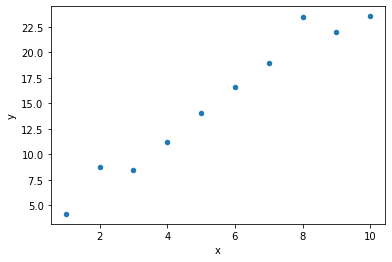

In [84]:
new_df.plot(x='x', y='y', kind='scatter')

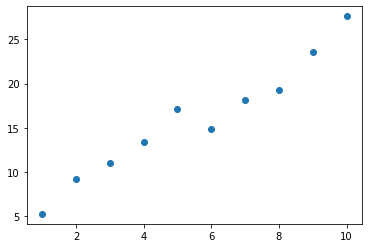

In [72]:
plt.scatter(x,y)

In [67]:
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [65]:
telco.tenure.describe()

count    7032.000000
mean       32.321246
std        24.324806
min        -3.281731
25%        12.108106
50%        26.691040
75%        49.020937
max       135.782276
Name: tenure, dtype: float64

In [31]:
x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'dept':['A1', 'A2'], 'price': [2.30, 3.20]})

In [36]:
rand_from_Finv?

In [46]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7032 non-null   float64
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [35]:
x.iloc[:,0]

0    T-LIGHT
1    ASHTRAY
Name: label, dtype: object

In [112]:
from scipy.interpolate import Akima1DInterpolator
from statsmodels.distributions.empirical_distribution import ECDF

def rand_from_Finv(X, size=(1,10), Xmin=None, Xmax = None):
    rvs_needed = np.array(size).prod()
    ecdf1 = ECDF(X)
    U = np.hstack((0.0, ecdf1.y[1:-1], 1.0))
    
    if Xmin is None:
        Xmin = X.min()
    if Xmax is None:
        Xmax = X.max()
        
    Finv = np.hstack((Xmin, ecdf1.x[1:-1], Xmax))
    ak2 = Akima1DInterpolator(U, Finv)

    U_rand = np.random.uniform(size=rvs_needed)
    out = ak2(U_rand).reshape(size)
    return out

In [42]:
def resample_residuals(df, ycol, Xcols):
    breakpoint()
    new_df = df.dropna()
    X = add_constant(new_df[[Xcols]])
    y = new_df[ycol]
    
    #drop_these = pd.isna(X.TotalCharges)
    #X = X[~drop_these]
    #y = y[~drop_these]
    
    m = OLS(y, X)
    o = m.fit()
    new_resid = rand_from_Finv(o.resid, rng, size=len(o.resid))
    
    #df[ycol] = o.predict(X) + new_resid
    
    return df

In [ ]:
resample_residuals(telco, 'tenure', 'TotalCharges').info()

---

## Insert outlier to influential point

In [118]:
#from statsmodels.stats.outliers_influence import *

In [111]:
class InsertOutliers(Stainer):
    """ Stainer to insert outliers at influential points using a linear model. """
    
    def __init__(self, name = "Inserts outliers", row_idx =[], col_idx = [], n=5):
        """ Constructor for InsertOutliers
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This should specify at least two columns. The first will
                 be used as the y-variable, and the others will be used as the X matrix.
        row_idx: int list, unused.
        n:       number of outliers to insert. The default is 5.
                 
        Raises
        ------
        ValueError
            If col_idx has length not equals to two, or the values are not consecutive.
        """
        if len(col_idx) < 2:
            raise ValueError("col_idx must contain at least two integers.")
        super().__init__(name, row_idx, col_idx)
        self.n = n
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        A ordinary least squares linear model is fit, using statsmodels. 
        
        The 5 most influential points are identified (using their leverage).
        
        The residuals for these 5 points are replaced by sampling from the 5% tails of the residual 
        distributions.
        
        This stainer should result in a similar fit, but slightly different diagnostics/statistics.
        
        The user should check if the new y-values are valid or not (e.g. are they negative when they 
        shouldn't be?)
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
            Modified dataframe, with some columns shifted "inwards"
        row_map : empty dictionary.
        col_map : empty dictionary.
       
        >>> rng = np.random.default_rng(12)
        >>> x = np.arange(1, 11)
        >>> x[-2:] = [15,16]

        >>> y = x*2 + 3 + rng.normal(scale=5, size=10)
        >>> org_df = pd.DataFrame({'x':x, 'y':y})

        >>> rr = InsertOutliers('test rr', [], [1,0], n=2)
        >>> new_df = rr.transform(org_df, rng)[0]

        >>> print(pd.concat((org_df, new_df), axis=1))
            x          y   x          y
        0   1   4.965866   1   4.965866
        1   2  12.230716   2  12.230716
        2   3  12.707942   3  12.707942
        3   4  14.619783   4  14.619783
        4   5  21.093881   5  21.093881
        5   6   8.972209   6   8.972209
        6   7  13.865223   7  13.865223
        7   8  12.396684   8  12.396684
        8  15  32.461237  15  39.217787
        9  16  39.993818  16  27.541544

        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()
        
        # drop missing values
        col_names = new_df.columns[col_idx]
        fit_df = new_df.iloc[:, col_idx].dropna()
        
        X = add_constant(fit_df.iloc[:, 1:])
        y = fit_df.iloc[:,0]
    
        # obtain a function to sample from residuals
        m = OLS(y, X)
        o = m.fit()
        Finv = rand_from_Finv(o.resid, rng, return_fn=True)
        
        # derive leverage
        hhh4 = pd.Series(np.diag(np.matmul(np.matmul(X.values, 
                                                     np.linalg.inv(np.matmul(np.transpose(X.values), X.values))), 
                                           np.transpose(X.values))))
        hhh4.index = X.index
        replace_these = hhh4.nlargest(self.n).index
        
        # sample from tails
        V = rng.random(size=self.n)
        W = [rng.uniform(0.0, 0.05,1)[0] if (x <= 0.5) else rng.uniform(0.95, 1.00, 1)[0] for x in V ]
        
        # only put new values where we could predict values; otherwise keep old y-values.
        new_y = o.predict(X.loc[replace_these,:]) + Finv(W)
        #f2 = df.copy(deep=True)
        new_df.loc[replace_these, col_names[0]] = new_y        
        
        end = time()
        self.update_history(f"Outliers in column {col_idx[0]} by sampling from residual distribution.", 
                            end-start)
        return new_df,{},{}

In [116]:
rng = np.random.default_rng(12)
x = np.arange(1, 11)
x[-2:] = [15,16]

y = x*2 + 3 + rng.normal(scale=5, size=10)
org_df = pd.DataFrame({'x':x, 'y':y})

#org_df.plot('x', 'y', kind='scatter');

rr = InsertOutliers('test rr', [], [1,0], n=2)
new_df = rr.transform(org_df, rng)[0]

#import matplotlib.pyplot as plt
#%matplotlib inline

print(pd.concat((org_df, new_df), axis=1))

    x          y   x          y
0   1   4.965866   1   4.965866
1   2  12.230716   2  12.230716
2   3  12.707942   3  12.707942
3   4  14.619783   4  14.619783
4   5  21.093881   5  21.093881
5   6   8.972209   6   8.972209
6   7  13.865223   7  13.865223
7   8  12.396684   8  12.396684
8  15  32.461237  15  39.217787
9  16  39.993818  16  27.541544


<AxesSubplot:xlabel='x', ylabel='y'>

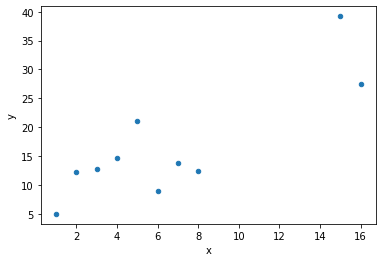

In [114]:
new_df.plot('x', 'y', kind='scatter')

In [144]:
def insert_outlier(df, ycol, Xcols, n=5):
    X = add_constant(df[[Xcols]])
    drop_these = pd.isna(X.TotalCharges)
    X = X[~drop_these]
    hhh4 = pd.Series(np.diag(np.matmul(np.matmul(X.values, 
                                                 np.linalg.inv(np.matmul(np.transpose(X.values), X.values))), 
                                       np.transpose(X.values))))
    hhh4.index = X.index
    replace_these = hhh4.nlargest(n).index
    
    y = df[ycol]
    y = y[~drop_these]
    m = OLS(y, X)
    o = m.fit()
    r1 = o.resid

    ecdf1 = ECDF(r1)
    Finv = np.hstack((r1.min(), ecdf1.x[1:-1], r1.max()))
    U = np.hstack((0.0, ecdf1.y[1:-1], 1.0))
    ak2 = Akima1DInterpolator(U, Finv)
    
    V = np.random.random(n)
    W = [np.random.uniform(0.0, 0.05,1)[0] if (x <= 0.5) else np.random.uniform(0.95, 1.00, 1)[0] for x in V ]
    
    new_y = o.predict(X.loc[replace_these,:]) + ak2(W)
    df2 = df.copy(deep=True)
    
    df2.loc[replace_these, ycol] = new_y
    return df2

---

## Modify Correlation

In [117]:
from scipy.stats import spearmanr,pearsonr,norm

In [147]:
class ModifyCorrelation(Stainer):
    """ Stainer to modify correlation between two columns. """
    
    def __init__(self, name = "Inserts outliers", row_idx =[], col_idx = [], rho=None):
        """ Constructor for ModifyCorrelation
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This should specify exactly two numeric columns.
        row_idx: int list, unused.
        rho:     New correlation between the two columns.
                 
        Raises
        ------
        ValueError
            If col_idx has length not equals to two, or the values are not consecutive.
        """
        if len(col_idx) != 2:
            raise ValueError("col_idx must contain exactly two integers.")
        if rho is None:
            raise ValueError("rho needs to specified.")
        super().__init__(name, row_idx, col_idx)
        self.rho = rho
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        A multivariate normal copula is used, with the Finv being fitted using the Akima interpolator.
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
        row_map : empty dictionary.
        col_map : empty dictionary.
       
        >>> rng = np.random.default_rng(12)
        >>> x = np.arange(0, 100)
        >>> y = x*2 + 3 + rng.normal(scale=25, size=100)
        >>> org_df = pd.DataFrame({'x':x, 'y':y})
        >>> spearmanr(org_df.x, org_df.y)[0]
        0.9324692469246924

        >>> rr = ModifyCorrelation('test rr', [], [1,0], rho=0.0)
        >>> new_df = rr.transform(org_df, rng)[0]
        >>> spearmanr(new_df.x, new_df.y)[0]
        0.12897689768976897
        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()

        # drop missing values
        col_names = new_df.columns[col_idx]
        fit_df = new_df.iloc[:, col_idx].dropna()
        
        # estimate Finv, Ginv
        X1 = fit_df.iloc[:, 0]
        Finv = rand_from_Finv(X1, rng, return_fn=True)
        X2 = fit_df.iloc[:, 1]
        Ginv = rand_from_Finv(X2, rng, return_fn=True)
        
        org_corr = spearmanr(X1, X2)[0]

        # sample multivariate normal with desired correlation
        mu = np.zeros(2)
        sigma = np.ones((2,2))
        sigma[0,1] = sigma[1,0] = self.rho
        Xn = rng.multivariate_normal(mu, sigma, size=new_df.shape[0], method='cholesky')

        # apply norm cdf to array
        Yn = norm.cdf(Xn)

        # apply Finv, Ginv
        new_col1 = Finv(Yn[:,0])
        new_col2 = Ginv(Yn[:,1])
        new_df.loc[:, col_names[0]] = new_col1
        new_df.loc[:, col_names[1]] = new_col2
        
        end = time()
        self.update_history(f"Correlation modified from {org_corr:.2f} to {self.rho:.2f}.", end-start)
        return new_df,{},{}

In [135]:
mm = ModifyCorrelation('test1', col_idx=[5,19], rho=-0.2)

In [137]:
tmp = mm.transform(telco, rng)

In [138]:
spearmanr(tmp.tenure, tmp.TotalCharges)

SpearmanrResult(correlation=-0.19078106560868513, pvalue=1.020258481195525e-58)

In [198]:
rng = np.random.default_rng(12)
x = np.arange(0, 100)
y = x*2 + 3 + rng.normal(scale=25, size=100)
org_df = pd.DataFrame({'x':x, 'y':y})

spearmanr(org_df.x, org_df.y)[0]

0.9324692469246924

<AxesSubplot:xlabel='x', ylabel='y'>

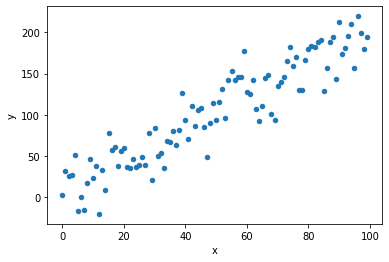

In [199]:
org_df.plot('x', 'y', kind='scatter')

In [200]:
#org_df.plot('x', 'y', kind='scatter');

rr = ModifyCorrelation('test rr', [], [1,0], rho=0.0)
new_df = rr.transform(org_df, rng)[0]

#print(pd.concat((org_df, new_df), axis=1))

spearmanr(new_df.x, new_df.y)[0]

0.12897689768976897

<AxesSubplot:xlabel='x', ylabel='y'>

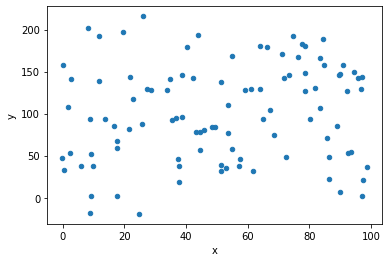

In [201]:
new_df.plot('x', 'y', kind='scatter')

In [ ]:
def modify_correlation(df, col1, col2, rho):
    # estimate/interpolate cdf for col1 and col2
    ecdf1 = ECDF(df[col1])
    Finv_step = np.hstack((df[col1].min(), ecdf1.x[1:-1], df[col1].max()))
    U = np.hstack((0.0, ecdf1.y[1:-1], 1.0))
    Finv = Akima1DInterpolator(U, Finv_step)

    ecdf2 = ECDF(df[col2])
    Ginv_step = np.hstack((df[col2].min(), ecdf2.x[1:-1], df[col2].max()))
    U = np.hstack((0.0, ecdf2.y[1:-1], 1.0))
    Ginv = Akima1DInterpolator(U, Ginv_step)
    
    # print original correlation
    org_corr = spearmanr(df[col1], df[col2])
    #print(f'The original spearman correlation is {org_corr[0]:.2f}.')
    
    # sample multivariate normal with desired correlation
    rng = default_rng()
    mu = np.zeros(2)
    sigma = np.ones((2,2))
    sigma[0,1] = sigma[1,0] = rho
    Xn = rng.multivariate_normal(mu, sigma, size=df.shape[0], method='cholesky')
    
    # apply norm cdf to array
    Yn = norm.cdf(Xn)
    
    # apply Finv, Ginv
    new_col1 = Finv(Yn[:,0])
    new_col2 = Ginv(Yn[:,1])
    
    df2 = df.copy(deep=True)
    df2[col1] = new_col1
    df2[col2] = new_col2
    
    # return df
    return df2

In [147]:
telco.tenure.describe()

count    7032.000000
mean       32.470025
std        24.459332
min        -3.952339
25%        12.364784
50%        26.509710
75%        48.953392
max       134.041232
Name: tenure, dtype: float64

In [87]:
X = telco[['TotalCharges']]
y = telco.tenure
X = add_constant(X)

In [101]:
hhh4 = pd.Series(np.diag(np.matmul(np.matmul(X.values, np.linalg.inv(np.matmul(np.transpose(X.values), X.values))), np.transpose(X.values))))

In [105]:
hhh4.tail()

7027    0.000145
7028    0.000856
7029    0.000246
7030    0.000250
7031    0.000718
dtype: float64

In [104]:
hhh.tail()

7038    0.000145
7039    0.000856
7040    0.000246
7041    0.000250
7042    0.000718
Name: hat_diag, dtype: float64

In [94]:
drop_these = pd.isna(X.TotalCharges)
X = X[~drop_these]
y = y[~drop_these]

In [71]:
m = OLS(y, X)

o = m.fit()

In [46]:
(y - (o.predict(X) + o.resid)).sum()

rand_from_Finv(o.resid, size=len(o.resid)).shape

In [60]:
y.shape

(7032,)

In [7]:
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [123]:
out['MultipleLines'] + out['OnlineBackup']

3900    NoNo internet service
4419    NoNo internet service
6752                      NaN
941                       NaN
5763                     NoNo
222     NoNo internet service
5028                    NoYes
5974    NoNo internet service
5620                   YesYes
380                     NoYes
dtype: object

In [117]:
out.shape

(10, 21)

In [46]:
tmp[['Description', 'InvoiceNo']]

,Description,InvoiceNo
3207,GLASS STAR FROSTED T,536609
1648,ALARM CLOCK BAKELIKE PINK,536544
4164,EDWARDIAN PARASOL BLACK,536750
4482,SET 7 BABUSHKA NESTING BOXES,536784


In [16]:
tmp

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,
4719,536798,21899,KEY FOB,", GARAGE DESIGN",2/12/2010 15:55,0.65,17838.00,United Kingdom,NaN
747,536446,20777,CHRYSANTHEMUM NOTEBOOK,None,2.0,1/12/2010 12:15,1.65,15983.0,United Kingdom
2132,536561,22274,FELTCRAFT DOLL EMILY,None,6.0,1/12/2010 15:06,2.95,12921.0,United Kingdom
3027,536592,90166,PINK & WHITE ROSEBUD RING,None,1.0,1/12/2010 17:06,4.24,NaN,United Kingdom


In [ ]:
pdb.runcall(column_splitter, d2, 'Description')

In [77]:
tmp.iloc[:, 5]

1097    NaN
4718    NaN
3193    NaN
4921    NaN
Name: , dtype: object

In [10]:
pd.DataFrame.combine_first?

Signature: pd.DataFrame.combine_first(self, other: 'DataFrame') -> 'DataFrame'
Docstring:
Update null elements with value in the same location in `other`.

Combine two DataFrame objects by filling null values in one DataFrame
with non-null values from other DataFrame. The row and column indexes
of the resulting DataFrame will be the union of the two.

Parameters
----------
other : DataFrame
    Provided DataFrame to use to fill null values.

Returns
-------
DataFrame

See Also
--------
DataFrame.combine : Perform series-wise operation on two DataFrames
    using a given function.

Examples
--------
>>> df1 = pd.DataFrame({'A': [None, 0], 'B': [None, 4]})
>>> df2 = pd.DataFrame({'A': [1, 1], 'B': [3, 3]})
>>> df1.combine_first(df2)
     A    B
0  1.0  3.0
1  0.0  4.0

Null values still persist if the location of that null value
does not exist in `other`

>>> df1 = pd.DataFrame({'A': [None, 0], 'B': [4, None]})
>>> df2 = pd.DataFrame({'B': [3, 3], 'C': [1, 1]}, index=[1, 2])
>>> df1.comb

In [30]:
id = pd.Series([True, False, False, True])

In [31]:
id.index = qty_series.index

In [32]:
qty_series[id] = d2.Description[id]

In [33]:
qty_series

3159    FULL ENGLISH BREAKFAST PLATE
3348                            12.0
4596                             2.0
4405     ZINC METAL HEART DECORATION
Name: Quantity, dtype: object

In [24]:
d2a = d2.Description.str.split('-',n=1, expand=True)

In [25]:
d2a[[1]]

,1
4608,None
1675,None
4451,None
1762,LIGHT HLDR


In [26]:
d2[["Quantity"]]

,Quantity
4608,1
1675,1
4451,108
1762,4


In [28]:
d2.combine_first?

Signature: d2.combine_first(other: 'DataFrame') -> 'DataFrame'
Docstring:
Update null elements with value in the same location in `other`.

Combine two DataFrame objects by filling null values in one DataFrame
with non-null values from other DataFrame. The row and column indexes
of the resulting DataFrame will be the union of the two.

Parameters
----------
other : DataFrame
    Provided DataFrame to use to fill null values.

Returns
-------
DataFrame

See Also
--------
DataFrame.combine : Perform series-wise operation on two DataFrames
    using a given function.

Examples
--------
>>> df1 = pd.DataFrame({'A': [None, 0], 'B': [None, 4]})
>>> df2 = pd.DataFrame({'A': [1, 1], 'B': [3, 3]})
>>> df1.combine_first(df2)
     A    B
0  1.0  3.0
1  0.0  4.0

Null values still persist if the location of that null value
does not exist in `other`

>>> df1 = pd.DataFrame({'A': [None, 0], 'B': [4, None]})
>>> df2 = pd.DataFrame({'B': [3, 3], 'C': [1, 1]}, index=[1, 2])
>>> df1.combine_first(df2)
 

In [27]:
pd.concat([d2a[[1]],d2[["Quantity"]]], axis=1)

,1,Quantity
4608,None,1
1675,None,1
4451,None,108
1762,LIGHT HLDR,4


In [65]:
oo.Description.str.contains("[^\w\s]", regex=True).isna().sum()

12

In [68]:
oo2 = oo[~oo.Description.isna()]

In [73]:
tmp = oo2[oo2.Description.str.contains("[^\w\s]", regex=True)].Description

In [77]:
tmp.str.split("(?=-)",n=1, expand=True)

,0,1
0,WHITE HANGING HEART T,-LIGHT HOLDER
4,RED WOOLLY HOTTIE WHITE HEART.,None
6,GLASS STAR FROSTED T,-LIGHT HOLDER
10,POPPY'S PLAYHOUSE BEDROOM,None
11,POPPY'S PLAYHOUSE KITCHEN,None
...,...,...
4969,SET OF 6 T,-LIGHTS SNOWMEN
4982,DINOSAUR PARTY BAG + STICKER SET,None
4986,EUCALYPTUS & PINECONE WREATH,None
4988,"SWISS ROLL TOWEL, CHOCOLATE SPOTS",None
